<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_11_resampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTEBOOK NO 11, resampling

**NOTE: THIS SCRIPT IS NOT POLISHED**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error


from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_diabetes


In [ ]:

# cal_housing.csv, read in
url = 'https://raw.githubusercontent.com/lorek/MethodsClassDimRed/main/files/cal_housing.csv'
df = pd.read_csv(url, on_bad_lines='skip',  sep = ',',  decimal='.')

In [ ]:
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41,880,129,322,126,8.3252,452600
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500
2,-122.24,37.85,52,1467,190,496,177,7.2574,352100
3,-122.25,37.85,52,1274,235,558,219,5.6431,341300
4,-122.25,37.85,52,1627,280,565,259,3.8462,342200


We will try to predict `medianHouseValue`

In [ ]:

# Prepare the feature matrix X and target vector y
X = df.drop(columns=['medianHouseValue']).values
y = df['medianHouseValue'].values

In [ ]:
url = 'https://raw.githubusercontent.com/lorek/MethodsClassDimRed/main/files/Concrete_Data_Yeh.csv'
df = pd.read_csv(url, on_bad_lines='skip',  sep = ',',  decimal='.')
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
X = df.drop('csMPa', axis=1)
y = df['csMPa']

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12)


We will fit several Ridge models:
$$\boldsymbol{\beta}^{opt} = \textrm{argmin}_{\boldsymbol{\beta}} \left( \sum_{i=1}^n (y_i-\boldsymbol{\beta}^T\mathbf{x}_i)^2 + \alpha\sum_{j=1}^d \beta_j^2\right)$$

searching for "best" parameter $\alpha$

In [ ]:

alpha_values = [0.1, 0.11,3, 6]

In [ ]:
# train model on whole train data, compute metric on test:

test_results = []

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)

    # Fit with entire training set and evaluate on test set
    ridge.fit(X_train, y_train)
    test_rmse = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))
    test_results.append((alpha, test_rmse))


test_results_sorted  = sorted(test_results, key=lambda x: x[1])

print("\nResults of Ridge with different alphas: (sorted by RMSE):")
for alpha, test_rmse in test_results_sorted:
    print(f"alpha: {alpha}, RMSE: \t\t {test_rmse:.6f}")



Results of Ridge with different alphas: (sorted by RMSE):
alpha: 6, RMSE: 		 10.734078
alpha: 3, RMSE: 		 10.734105
alpha: 0.11, RMSE: 		 10.734131
alpha: 0.1, RMSE: 		 10.734132


# $k$-fold cross validation vs single split:

In [ ]:

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the mean RMSE from cross-validation and single split
cv_results = []
single_split_results = []

# Perform k-fold cross-validation for each alpha
for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    rmse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        ridge.fit(X_train_kf, y_train_kf)
        y_val_pred = ridge.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, y_val_pred))
        rmse_scores.append(rmse)

    mean_rmse = np.mean(rmse_scores)
    cv_results.append((alpha, mean_rmse))

# Perform a single train-validation split for each alpha
X_train_single, X_val_single, y_train_single, y_val_single = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_single, y_train_single)
    y_val_pred = ridge.predict(X_val_single)
    single_split_rmse = np.sqrt(mean_squared_error(y_val_single, y_val_pred))
    single_split_results.append((alpha, single_split_rmse))

# Sort the cross-validation results by mean RMSE
cv_results_sorted = sorted(cv_results, key=lambda x: x[1])

print("K-Fold Cross-Validation Results (sorted by mean RMSE):")
for alpha, mean_rmse in cv_results_sorted:
    print(f"alpha: {alpha}, Mean RMSE: \t\t {mean_rmse:.8f}")

# Sort the single split results by RMSE
single_split_results_sorted = sorted(single_split_results, key=lambda x: x[1])

print("\nSingle Train-Validation Split Results (sorted by RMSE):")
for alpha, single_split_rmse in single_split_results_sorted:
    print(f"alpha: {alpha}, RMSE: \t\t {single_split_rmse:.8f}")


print("\nRECALL results of Ridge with different alphas: (sorted by RMSE):")
for alpha, test_rmse in test_results_sorted:
    print(f"alpha: {alpha}, RMSE: \t\t {test_rmse:.6f}")


K-Fold Cross-Validation Results (sorted by mean RMSE):
alpha: 6, Mean RMSE: 		 10.35159142
alpha: 3, Mean RMSE: 		 10.35159900
alpha: 0.11, Mean RMSE: 		 10.35160634
alpha: 0.1, Mean RMSE: 		 10.35160637

Single Train-Validation Split Results (sorted by RMSE):
alpha: 0.1, RMSE: 		 11.47668012
alpha: 0.11, RMSE: 		 11.47668019
alpha: 3, RMSE: 		 11.47670029
alpha: 6, RMSE: 		 11.47672116

RECALL results of Ridge with different alphas: (sorted by RMSE):
alpha: 6, RMSE: 		 10.734078
alpha: 3, RMSE: 		 10.734105
alpha: 0.11, RMSE: 		 10.734131
alpha: 0.1, RMSE: 		 10.734132


# bootstrap

In [ ]:
from sklearn.utils import resample

Bootstrap RMSE (mean): 10.8492
Bootstrap RMSE (std): 0.1661
Bootstrap RMSE (95% CI): (10.6195, 11.2936)


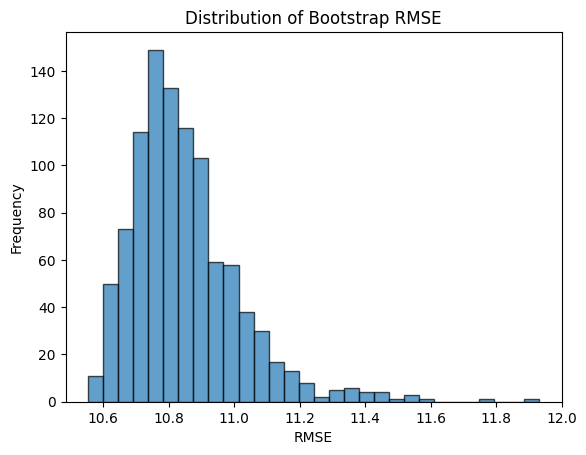

In [ ]:
# Define the model and parameter
alpha = 1
ridge = Ridge(alpha=alpha)

# Number of bootstrap samples
n_bootstrap_samples = 1000

# Store RMSE for each bootstrap sample
bootstrap_rmse = []

# Bootstrap process
for _ in range(n_bootstrap_samples):
    # Sample with replacement from the training data
    X_train_sample, y_train_sample = resample(X_train, y_train)

    # Fit the model on the bootstrap sample
    ridge.fit(X_train_sample, y_train_sample)

    # Predict on the test set
    y_test_pred = ridge.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    bootstrap_rmse.append(rmse)

# Convert the list to a numpy array for further analysis
bootstrap_rmse = np.array(bootstrap_rmse)

# Print the bootstrap results
print(f"Bootstrap RMSE (mean): {bootstrap_rmse.mean():.4f}")
print(f"Bootstrap RMSE (std): {bootstrap_rmse.std():.4f}")
print(f"Bootstrap RMSE (95% CI): ({np.percentile(bootstrap_rmse, 2.5):.4f}, {np.percentile(bootstrap_rmse, 97.5):.4f})")

# Plot the distribution of bootstrap RMSE
plt.hist(bootstrap_rmse, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Bootstrap RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

# bootstrap vs kfold, finding $\alpha$

In [ ]:

# K-Fold Cross-Validation
kf_rmse_mean = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    kf_rmse = []

    for train_index, val_index in kf.split(X_train):
        X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[val_index]

        ridge.fit(X_train_kf, y_train_kf)
        y_val_pred = ridge.predict(X_val_kf)
        rmse = np.sqrt(mean_squared_error(y_val_kf, y_val_pred))
        kf_rmse.append(rmse)

    kf_rmse_mean.append(np.mean(kf_rmse))

# Find the best alpha from K-Fold CV
best_alpha_kf = alpha_values[np.argmin(kf_rmse_mean)]
print(f"Best alpha (K-Fold CV): {best_alpha_kf}")

# Evaluate the model with the best alpha on the test set
ridge = Ridge(alpha=best_alpha_kf)
ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)
test_rmse_kf = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test Set RMSE (K-Fold CV): {test_rmse_kf:.4f}")

# Bootstrap
bootstrap_rmse_mean = []
bootstrap_results = []
n_bootstrap_samples = 100

for alpha in alpha_values:
    ridge = Ridge(alpha=alpha)
    bootstrap_rmse = []

    for _ in range(n_bootstrap_samples):
        # Sample with replacement from the training data
        X_train_sample, y_train_sample = resample(X_train, y_train)

        # Fit the model on the bootstrap sample
        ridge.fit(X_train_sample, y_train_sample)

        # Predict on the test set
        y_test_pred = ridge.predict(X_test)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        bootstrap_rmse.append(rmse)

    mean_rmse = np.mean(bootstrap_rmse)
    bootstrap_rmse_mean.append(mean_rmse)
    bootstrap_results.append((alpha, mean_rmse))

# Sort the bootstrap results by mean RMSE
bootstrap_results_sorted = sorted(bootstrap_results, key=lambda x: x[1])

print("\nBootstrap Results (sorted by mean RMSE):")
for alpha, mean_rmse in bootstrap_results_sorted:
    print(f"alpha: {alpha}, Mean RMSE: {mean_rmse:.4f}")

# Find the best alpha from Bootstrap
best_alpha_bootstrap = alpha_values[np.argmin(bootstrap_rmse_mean)]
print(f"\nBest alpha (Bootstrap): {best_alpha_bootstrap}")

# Evaluate the model with the best alpha on the test set
ridge = Ridge(alpha=best_alpha_bootstrap)
ridge.fit(X_train, y_train)
y_test_pred = ridge.predict(X_test)
test_rmse_bootstrap = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test Set RMSE (Bootstrap): {test_rmse_bootstrap:.4f}")

# Print and compare results
print(f"\nK-Fold CV best alpha: {best_alpha_kf} with Test RMSE: {test_rmse_kf:.4f}")
print(f"Bootstrap best alpha: {best_alpha_bootstrap} with Test RMSE: {test_rmse_bootstrap:.4f}")

print("\nRECALL K-Fold Cross-Validation Results (sorted by mean RMSE):")
for alpha, mean_rmse in cv_results_sorted:
    print(f"alpha: {alpha}, Mean RMSE: \t\t {mean_rmse:.8f}")

print("\nRECALL Single Train-Validation Split Results (sorted by RMSE):")
for alpha, single_split_rmse in single_split_results_sorted:
    print(f"alpha: {alpha}, RMSE: \t\t {single_split_rmse:.8f}")

print("\nRECALL results of Ridge with different alphas: (sorted by RMSE):")
for alpha, test_rmse in test_results_sorted:
    print(f"alpha: {alpha}, RMSE: \t\t {test_rmse:.6f}")


Best alpha (K-Fold CV): 6
Test Set RMSE (K-Fold CV): 10.7341

Bootstrap Results (sorted by mean RMSE):
alpha: 0.1, Mean RMSE: 10.8420
alpha: 3, Mean RMSE: 10.8464
alpha: 0.11, Mean RMSE: 10.8544
alpha: 6, Mean RMSE: 10.8547

Best alpha (Bootstrap): 0.1
Test Set RMSE (Bootstrap): 10.7341

K-Fold CV best alpha: 6 with Test RMSE: 10.7341
Bootstrap best alpha: 0.1 with Test RMSE: 10.7341

RECALL K-Fold Cross-Validation Results (sorted by mean RMSE):
alpha: 6, Mean RMSE: 		 10.35159142
alpha: 3, Mean RMSE: 		 10.35159900
alpha: 0.11, Mean RMSE: 		 10.35160634
alpha: 0.1, Mean RMSE: 		 10.35160637

RECALL Single Train-Validation Split Results (sorted by RMSE):
alpha: 0.1, RMSE: 		 11.47668012
alpha: 0.11, RMSE: 		 11.47668019
alpha: 3, RMSE: 		 11.47670029
alpha: 6, RMSE: 		 11.47672116

RECALL results of Ridge with different alphas: (sorted by RMSE):
alpha: 6, RMSE: 		 10.734078
alpha: 3, RMSE: 		 10.734105
alpha: 0.11, RMSE: 		 10.734131
alpha: 0.1, RMSE: 		 10.734132


Kfold cross validation -- more models

In [ ]:

# Define the models
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor()
}

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and print results for each model
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{name} RMSE Scores (Training Set): {rmse_scores}")
    print(f"{name} Mean RMSE (Training Set): {rmse_scores.mean()}\n")

# Train and evaluate the final models on the test set
for name, model in models.items():
    model.fit(X_train, y_train)
    test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    print(f"{name} RMSE (Test Set): {test_rmse}")

Linear Regression RMSE Scores (Training Set): [11.47667942 10.82163564  9.60302211 10.1875089   9.66918703]
Linear Regression Mean RMSE (Training Set): 10.351606620004244

Lasso Regression RMSE Scores (Training Set): [11.48786411 10.80296692  9.64258034 10.17820629  9.66777418]
Lasso Regression Mean RMSE (Training Set): 10.355878367628533

Ridge Regression RMSE Scores (Training Set): [11.47668638 10.82161224  9.60304782 10.18749157  9.66918237]
Ridge Regression Mean RMSE (Training Set): 10.351604075009131

Decision Tree Regressor RMSE Scores (Training Set): [6.40938848 9.41886418 8.88409234 7.07725753 8.37815127]
Decision Tree Regressor Mean RMSE (Training Set): 8.03355076104086

Random Forest Regressor RMSE Scores (Training Set): [5.31697601 5.9180615  4.80632295 4.65213911 5.65915534]
Random Forest Regressor Mean RMSE (Training Set): 5.270530980155871

Gradient Boosting Regressor RMSE Scores (Training Set): [5.37740045 6.10032712 4.58158266 5.04596826 5.59280407]
Gradient Boosting Re

In [ ]:

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300]
}

# Define the k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV to find the best hyperparameter
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", best_params)

# Evaluate the best model on the test set
best_rf.fit(X_train, y_train)
test_rmse = np.sqrt(mean_squared_error(y_test, best_rf.predict(X_test)))

print("\nRandom Forest Regressor RMSE (Test Set):", test_rmse)

#Q11.1 **TO DO**